In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb
import scipy as sp
from PIL import Image
import sys, os, time
sys.path.append(os.path.abspath("../../"))
from pipeoptz import Pipeline, Node, PipelineOptimizer, BoolParameter, IntParameter

In [2]:
def ith_subset(n, i):
    total = 2**n
    if i < 0 or i >= total:
        raise ValueError(f"Index i must be in [0, {total - 1}]")

    remaining = i
    for k in range(n + 1):
        c = comb(n, k)
        if remaining < c:
            cardinality = k
            break
        remaining -= c

    subset = []
    x = 0
    for j in range(cardinality):
        while comb(n-1 - x, cardinality - j - 1) <= remaining:
            remaining -= comb(n-1 - x, cardinality - j - 1)
            x += 1
        subset.append(x)
        x += 1
    return subset

def integer(n):
    return n

def to_mask(image):
    return image[:,:,3] != 0

def biggest_mask(elements):
    size = []
    if len(elements) != 0:
        for el in elements:
            size.append(el.sum())
        return elements[size.index(max(size))]
    else:
        return None

def colored_mask(image, mask):
    if mask is not None:
        return image*mask[:,:,np.newaxis]
    else:
        return np.zeros(shape=image.shape)

def extract_palette(image, n_colors, sample_size=0, max_iter=300, use_lab=False):
    if image.shape[2] == 4:
        opaque_mask = image[:, :, 3] != 0
        pixels = image[opaque_mask][:, :3]
        if pixels.shape[0] == 0:
            return np.array([], dtype=np.uint8).reshape(0, 3)
    elif image.shape[2] == 3:  # RGB
        pixels = image.reshape(-1, 3)
    else:
        raise ValueError("Image must be RGB or RGBA.")
    
    if use_lab:
        pixels_normalized = pixels.astype(np.float32) / 255.0
        data_for_kmeans = rgb2lab(pixels_normalized)
    else:
        data_for_kmeans = pixels.astype(np.float32)

    if sample_size > 0 and data_for_kmeans.shape[0] > sample_size:
        indices = np.random.choice(data_for_kmeans.shape[0], size=sample_size, replace=False)
        sample = data_for_kmeans[indices]
    else:
        sample = data_for_kmeans

    if sample.shape[0] < n_colors:
        n_colors = max(1, sample.shape[0])
        if n_colors == 0:
            return np.array([], dtype=np.uint8).reshape(0, 3)

    kmeans = KMeans(n_clusters=n_colors, max_iter=max_iter, n_init='auto', random_state=0)
    kmeans.fit(sample)
    centers = kmeans.cluster_centers_

    if use_lab:
        palette_float = lab2rgb(centers)
        palette = np.clip(palette_float * 255, 0, 255).astype(np.uint8)
        l_values = centers[:, 0]
        sorted_indices = np.argsort(l_values)[::-1]
        palette = palette[sorted_indices]
    else:
        palette_float = centers
        palette = np.clip(palette_float, 0, 255).astype(np.uint8)
        luminance = 0.299 * palette[:, 0] + 0.587 * palette[:, 1] + 0.114 * palette[:, 2]
        sorted_indices = np.argsort(luminance)[::-1]
        palette = palette[sorted_indices]
        
    return palette

def recolor(image, palette) :
    h, w, c = image.shape
    is_rgba = (c == 4)
    
    rgb_image_part = image[:, :, :3].astype(np.float32)
    pixels_flat = rgb_image_part.reshape(-1, 3)
    palette_float = palette.astype(np.float32)

    dists = np.linalg.norm(pixels_flat[:, np.newaxis, :] - palette_float[np.newaxis, :, :], axis=2)
    
    nearest_palette_indices = np.argmin(dists, axis=1)
    recolored_rgb_flat = palette[nearest_palette_indices]
    recolored_rgb = recolored_rgb_flat.reshape(h, w, 3).astype(np.uint8)

    if is_rgba:
        alpha_channel = image[:, :, 3:]
        return np.dstack((recolored_rgb, alpha_channel))
    return recolored_rgb

def remove_palette(image, recolored_image, palette, indices_to_remove):
    if image.shape[2] != 4:
        raise ValueError("Original image must be RGBA.")

    output_image = image.copy()
    recolored_rgb = recolored_image[:,:,:3]

    for i in indices_to_remove:
        if 0 <= i < len(palette):
            color_to_match = palette[i]
            match_mask = np.all(recolored_rgb == color_to_match, axis=2)
            output_image[match_mask, 3] = 0
    return output_image

def isolate(binary_mask, sizemin=1):
    if not np.any(binary_mask):
        return []
    labeled_array, num_features = sp.ndimage.label(binary_mask)
    
    elements = []
    for i in range(1, num_features + 1):
        component_mask = (labeled_array == i)
        if np.sum(component_mask) >= sizemin:
            elements.append(component_mask)
    return elements


In [3]:
def IoU(im1, im2):
    f1 = im1[:,:,3]==255
    f2 = im2[:,:,3]==255
    intersection = (f1 & f2).sum()
    union = (f1 | f2).sum()
    return intersection / union if union > 0 else 0

def loss(f1, f2):
    return 1/(IoU(f1, f2)+1e-20)

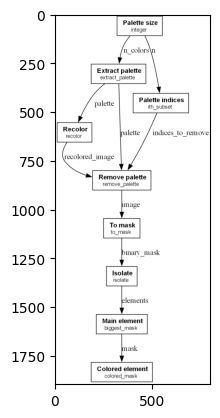

In [4]:
pipeline = Pipeline("RemoveBG")

pipeline.add_node(Node("Palette size", integer, fixed_params={"n":8}))
pipeline.add_node(Node("Extract palette", extract_palette, fixed_params={"use_lab":False}), predecessors={"image":"run_params:image", "n_colors":"Palette size"})
pipeline.add_node(Node("Palette indices", ith_subset, fixed_params={"i": 37}), predecessors={"n":"Palette size"})
pipeline.add_node(Node("Recolor", recolor), predecessors={"image":"run_params:image", "palette":"Extract palette"})
pipeline.add_node(Node("Remove palette", remove_palette), predecessors={"image":"run_params:image", "recolored_image":"Recolor", "palette":"Extract palette", "indices_to_remove":"Palette indices"})
pipeline.add_node(Node("To mask", to_mask), predecessors={"image":"Remove palette"})
pipeline.add_node(Node("Isolate", isolate), predecessors={"binary_mask": "To mask"})
pipeline.add_node(Node("Main element", biggest_mask), predecessors={"elements":"Isolate"})
pipeline.add_node(Node("Colored element", colored_mask), predecessors={"image":"run_params:image", "mask":"Main element"})

pipeline.to_dot("RemoveBG.dot", True)
im = np.array(Image.open("RemoveBG.png"))
os.remove("RemoveBG.dot")
os.remove("RemoveBG.png")
plt.imshow(im)

In [5]:
optimizer = PipelineOptimizer(pipeline, loss, 0.1)
optimizer.add_param(IntParameter("Palette size", "n", 8, 15))
optimizer.add_param(IntParameter("Palette indices", "i", 1, 63))
optimizer.add_param(BoolParameter("Extract palette", "use_lab"))

### Lolipop Dataset

In [6]:
X = []
y = []
for i in range(5):
    X.append({"image":np.array(Image.open(f"images/lolipop/{i}.png"))})
    y.append(np.array(Image.open(f"images/lolipop/edited/{i}.png")))

In [7]:
params_and_log = {}
times = {}
methods = {"ACO":{"iterations":15, "ants":15},
           "SA":{"iterations":100}, 
           "PSO":{"iterations":10, "swarm_size":15}, 
           "GA":{"generations":10, "population_size":20}, 
           "GS":{"max_combinations":200}, 
           "BO":{"iterations":30, "init_points":50}}

for i, method in enumerate(methods):
    t = time.time()
    print(f"Method {method} :")
    params_and_log[method] = optimizer.optimize(X, y, method=method, verbose=True, **methods[method])
    times[method] = time.time()-t
    print()

Method ACO :
Iteration 15/15
Method SA :
Iteration 100/100
Method PSO :
Iteration 10/10
Method GA :
Generation 10/10
Method GS :
Iteration 200/200
Method BO :
Iteration 30/30


{'Palette size.n': np.int64(8), 'Extract palette.use_lab': np.True_, 'Palette indices.i': np.int64(1)}
{'Palette size.n': 8, 'Extract palette.use_lab': True, 'Palette indices.i': 1}
{'Palette size.n': 13, 'Extract palette.use_lab': False, 'Palette indices.i': 14}
{'Palette size.n': 12, 'Extract palette.use_lab': False, 'Palette indices.i': 13}
{'Palette size.n': 11, 'Extract palette.use_lab': True, 'Palette indices.i': 13}
{'Palette size.n': 14, 'Extract palette.use_lab': False, 'Palette indices.i': 15}


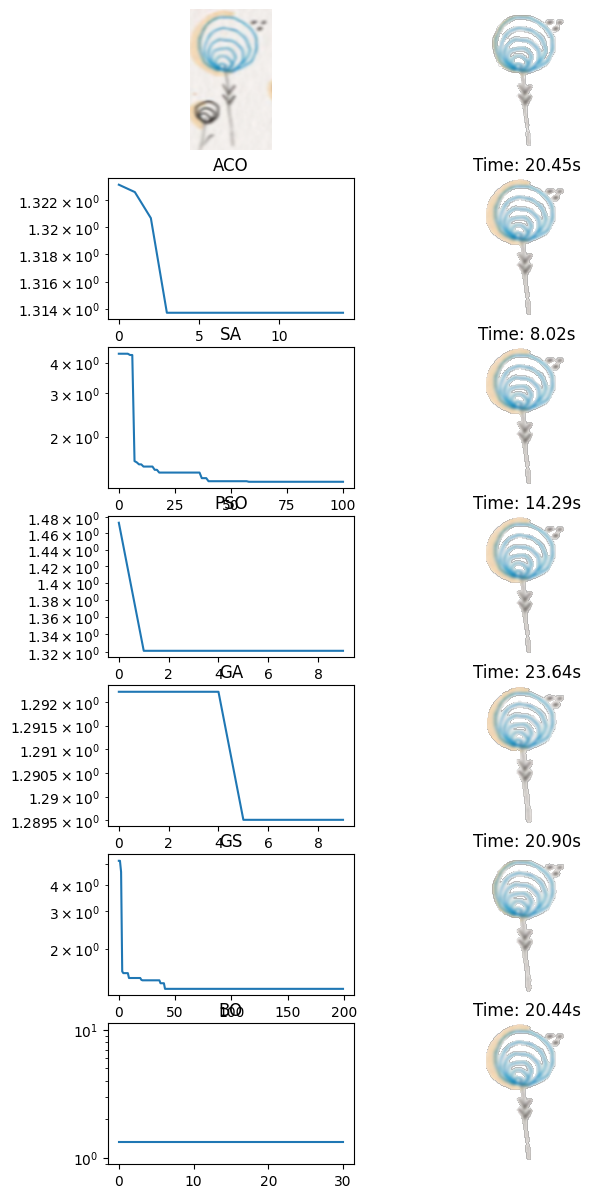

In [8]:
plt.figure(figsize=(7, 15))
plt.subplot(7, 2, 1)
plt.axis('off')
plt.imshow(X[0]["image"])
plt.subplot(7, 2, 2)
plt.axis('off')
plt.imshow(y[0])

ims = []
for i, method in enumerate(methods):
    pipeline.set_fixed_params(params_and_log[method][0])
    print(pipeline.get_fixed_params())
    ind, hist, _ = pipeline.run(X[0])
    ims.append(hist[ind])
    
    plt.subplot(7, 2, 3+2*i)
    plt.gca().set_yscale('log')
    plt.title(method)
    plt.plot(params_and_log[method][1])

    plt.subplot(7, 2, 4+2*i)
    plt.axis('off')
    plt.title(f"Time: {times[method]:.2f}s")
    plt.imshow(ims[-1], cmap="gray", vmin=0, vmax=255)

In [9]:
print("\t"+"\t".join(list(methods.keys())))
for i in range(len(ims)):
    print(list(methods.keys())[i], end="\t")
    for j in range(i+1):
        print(round(IoU(ims[i], ims[j]),2), end="\t")
    print()

	ACO	SA	PSO	GA	GS	BO
ACO	1.0	
SA	1.0	1.0	
PSO	0.98	0.98	1.0	
GA	0.87	0.87	0.85	1.0	
GS	0.79	0.79	0.76	0.86	1.0	
BO	0.99	0.99	0.99	0.86	0.77	1.0	


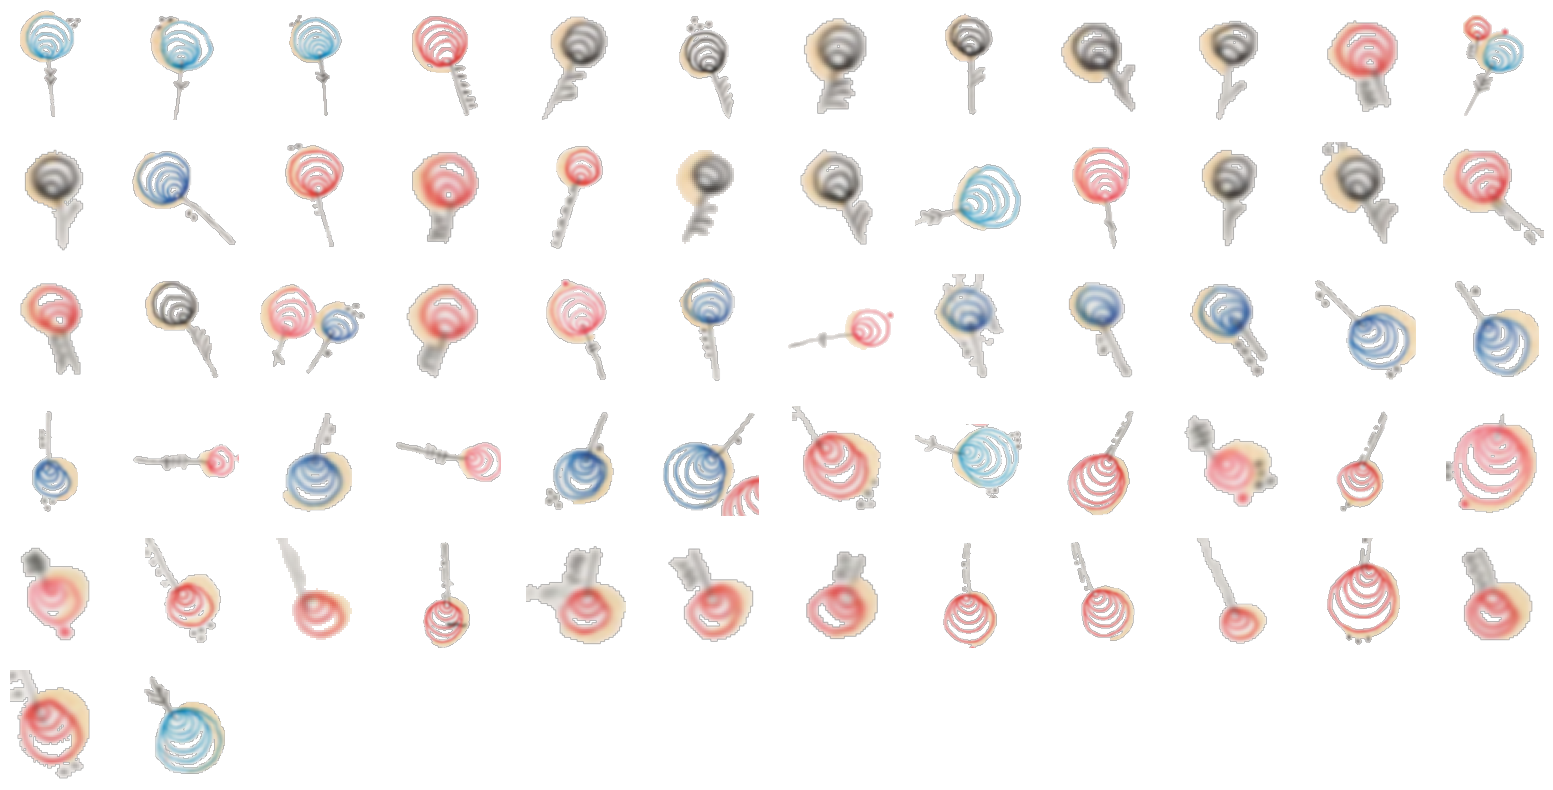

In [10]:
plt.figure(figsize=(20, 10))
for i in range(62):
    print(f"{i+1}/62", end="\t\r")
    plt.subplot(62//12+1, 12, i+1)
    im = np.array(Image.open(f"images/lolipop/{i}.png"))
    res = pipeline.run({"image":im})
    plt.axis('off')
    plt.imshow(res[1][res[0]])

### Goodbye Dataset

In [14]:
X2 = []
y2 = []
for i in range(5):
    X2.append({"image":np.array(Image.open(f"images/goodbye/{i}.png"))})
    y2.append(np.array(Image.open(f"images/goodbye/edited/{i}.png")))

In [15]:
params_and_log2 = {}
times2 = {}
methods2 = {"ACO":{"iterations":15, "ants":15},
           "SA":{"iterations":100}, 
           "PSO":{"iterations":10, "swarm_size":15}, 
           "GA":{"generations":10, "population_size":20}, 
           "GS":{"max_combinations":200}, 
           "BO":{"iterations":30, "init_points":50}}

for i, method in enumerate(methods2):
    t = time.time()
    print(f"Method {method} :")
    params_and_log2[method] = optimizer.optimize(X, y, method=method, verbose=True, **methods2[method])
    times2[method] = time.time()-t
    print()

Method ACO :
Iteration 15/15
Method SA :
Iteration 100/100
Method PSO :
Iteration 10/10
Method GA :
Generation 10/10
Method GS :
Iteration 200/200
Method BO :
Iteration 30/30


{'Palette size.n': np.int64(12), 'Extract palette.use_lab': np.False_, 'Palette indices.i': np.int64(13)}
{'Palette size.n': 12, 'Extract palette.use_lab': True, 'Palette indices.i': 14}
{'Palette size.n': 11, 'Extract palette.use_lab': False, 'Palette indices.i': 12}
{'Palette size.n': 13, 'Extract palette.use_lab': True, 'Palette indices.i': 14}
{'Palette size.n': 13, 'Extract palette.use_lab': False, 'Palette indices.i': 14}
{'Palette size.n': 12, 'Extract palette.use_lab': False, 'Palette indices.i': 13}


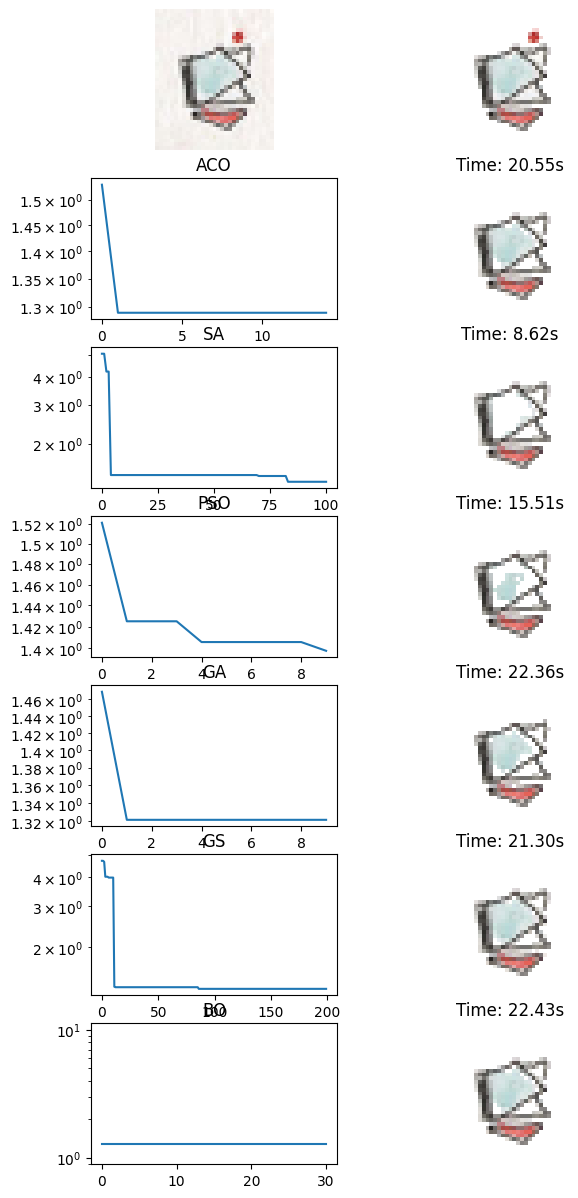

In [16]:
plt.figure(figsize=(7,15))
plt.subplot(7, 2, 1)
plt.axis('off')
plt.imshow(X2[0]["image"])
plt.subplot(7, 2, 2)
plt.axis('off')
plt.imshow(y2[0])

ims2 = []
for i, method in enumerate(methods2):
    pipeline.set_fixed_params(params_and_log2[method][0])
    print(pipeline.get_fixed_params())
    ind, hist, _ = pipeline.run(X2[0])
    ims2.append(hist[ind])
    
    plt.subplot(7, 2, 3+2*i)
    plt.gca().set_yscale('log')
    plt.title(method)
    plt.plot(params_and_log2[method][1])

    plt.subplot(7, 2, 4+2*i)
    plt.axis('off')
    plt.title(f"Time: {times2[method]:.2f}s")
    plt.imshow(ims2[-1], cmap="gray", vmin=0, vmax=255)